In [1]:
import xml.etree.cElementTree as et 
import os, glob, shutil
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import cv2

## 删除训练文件夹中的所有JPG和XML文件 

In [4]:
#设置删除状态为False，防止误操作
delete = False
base_dir=r'./train-cam-xml/'
if delete:
    dirs = os.listdir(base_dir)
    for p in dirs:
        if p == 'img' or p == 'xml':
            continue
        path = os.path.join(base_dir,p)
        for f in os.listdir(path):
            try:
                f = os.path.join(base_dir,p,f)
                os.remove(f)
                print('Remove ',f)
            except:
                continue

In [5]:
base_dir=r'./train-cam-xml/'
for pic in glob.glob(r'./train-cam-xml/img/*.jpg'):
    camera_id=int(os.path.basename(pic).split('.')[0].split('_')[-1][1])
    img_dirname=r'./train-cam-xml/cam%i'%camera_id
    xml_dirname=r'./train-cam-xml/cam%i-xml'%camera_id
    os.makedirs(img_dirname,exist_ok=True)
    os.makedirs(xml_dirname,exist_ok=True)
    shutil.copy(pic,os.path.join(img_dirname,os.path.basename(pic)))
    xml_path=r'./train-cam-xml/xml/%s'%os.path.splitext(os.path.basename(pic))[0]+'.xml'
    if not os.path.exists(xml_path): 
        print('xml of %s not found'%os.path.basename(xml_path))
        continue
    shutil.copy(xml_path,os.path.join(xml_dirname,os.path.basename(xml_path)))

In [6]:
def get_dots_by_xml(xml_path):  #从XML文件获取关键点/标签
    '''
    从XML文件中获取所有角点坐标
    '''
    tree = et.parse(xml_path)  #从硬盘的xml文件读取数据 
    root = tree.getroot()      #加载XML 得到根节点 
    dots = []
    for obj in root.findall('object'):  #获得所有对象框
        name = obj.find('name').text    # 获取节点\对象框名
        bbox = obj.find('bndbox')       #查找bnbox，找到四个角点
        bbox = [int(bbox.find(tag).text) for tag in ['xmin', 'ymin', 'xmax', 'ymax']]#获取四个角点坐标
        dot = bbox[:2]          #找出左上角角点坐标
        dots.append(dot)        #把所有点加入dots
    return np.array(dots)        

def generate_objpoints_dict(xml_dir):  
    '''生成objpoints字典'''
    xmllist = glob.glob(os.path.join(xml_dir, '*.xml'))  #xml_dir文件夹下以xml结尾的文件
    #如果文件名是已知的，那么参数为“./filename”或者“filename”
    dot_dict = {}
    for xml in xmllist:
        dots = get_dots_by_xml(xml)#遍历每个xml文件的关键点
        if len(dots) != 35:
            print(xml)
        dot_dict[xml] = dots
    return dot_dict#返回每个xml文件的关键点汇总为字典

def reorganize_dots(dot_dict, x_num, y_num):#传入关键点字典 ，横纵坐标点个数
    '''重组关键点 '''
    new_dot_dict = {}
    for k, d in dot_dict.items():#遍历dot_dict的键和dot  d是矩阵
        try:
            assert x_num * y_num == len(d), 'total dots num are %i, x: %i, y: %i' % (len(d), x_num, y_num)#计算总点数
            #print(k,d)
            xs, ys = d.T                                                                            
            d = d[xs.argsort()]  #argsort函数返回的是数组值从小到大的索引值
            argsort = np.array([])
            for i in range(x_num):
                cluster = d[:,1][y_num * i:y_num * (i + 1)]
                argsort = np.append(argsort, cluster.argsort() + (i * y_num))
            new_dot_dict[k] = d[argsort.astype(np.uint32)].astype(np.float32)
        except Exception as e:
            print('Warning: Something wrong,', e)
    return new_dot_dict

def generate_world_points(x_num, y_num):
    '''生成世界坐标点'''
    xs, ys = np.meshgrid(np.arange(y_num), np.arange(x_num))#np.arange() 生成(start,stop)区间指定步长step的list
    world_points = np.array([x.ravel() for x in [ys, xs, np.zeros(xs.shape)]]).T
    return world_points.astype(np.float32)

def calibration(dot_dict, x_num, y_num, img_size, pkl_savepath = './dist_pickle.pkl'):#校准
    '''相机标定'''
    imgpoints = [v.astype(np.float32) for v in dot_dict.values()]#item={key:value}   2D图像点
    objpoints = [generate_world_points(x_num, y_num) for v in dot_dict.values()]   # 图像点生成世界坐标系之后，成为真实世界3D坐标点
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)
    #标定 返回摄像机矩阵 畸变系数 旋转和变换向量等。
    
    dist_pickle = {}# 保存标定结果
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open(pkl_savepath, "wb" ))# pickle.dump(obj, file[, protocol]) 将结果数据流写入到文件对象中序列化永久保存

    
def get_img_size_by_xml(xml_dir):
    '''从xml文件中得出图片尺寸'''
    hs, ws = [], []
    for xml in glob.glob(os.path.join(xml_dir, '*.xml')):
        try:
            tree = et.parse(xml)
            root = tree.getroot()
            h = int(root.find('size').find('height').text)#从xml文件之中读取图片宽高
            w = int(root.find('size').find('width').text)
            hs.append(h)
            ws.append(w)
        except Exception as e:
            print(Exception, 'error xml in %s' % xml)#如果没有正常读取则提示报错            
    assert h == np.mean(hs), 'xmls are from different size of images'
    return h, w

def calibrate_camera(xml_dir, x_num, y_num, pkl_savepath = './dist_pickle.pkl', debug = False):
    '''整体标定函数,并保存PKL文件'''
    img_size = get_img_size_by_xml(xml_dir)#先得出图片尺寸
    dot_dict = generate_objpoints_dict(xml_dir)#生成objpoints字典
    new_dots = reorganize_dots(dot_dict, x_num, y_num)#重组objpoints
    
    '''
    if debug:
        
        for k, v in new_dots.items():
            i = 0
            plt.scatter(v.T[0], v.T[1])
            for xs, ys in v:
                plt.annotate(s = '%i' % i, xy=(xs, ys))
                i += 1
            plt.show()
     '''
    
    calibration(new_dots, x_num, y_num, img_size, pkl_savepath)#标定 的同时保存PKL文件
    #生成世界坐标点函数在calibration函数已经调用，不用重新调用
    print('finish calibration! pkl saved at %s' % os.path.abspath(pkl_savepath))#可视化保存PKL过程

if __name__ == '__main__':
    #path = r'./xmls'
    #path = r'./cam1-xml'
    for i in range(1,5):
        '''循环给出四个XML文件读取矫正并循环生成四个PKL文件'''
        path = './train-cam-xml/cam%d-xml'%i   
        #plt.rc('figure', figsize = (25, 10))
        calibrate_camera(path, 4, 3, './camera_param/cam%d.pkl'%i, debug  =True)

./train-cam-xml/cam1-xml/3271938223898_1_A1.xml
./train-cam-xml/cam1-xml/3271938223898_1_C1.xml
./train-cam-xml/cam1-xml/3272009223986_B1.xml
./train-cam-xml/cam1-xml/3271938223898_1_B1.xml
./train-cam-xml/cam1-xml/3271938223297_A1.xml
./train-cam-xml/cam1-xml/3272009223986_C1.xml
./train-cam-xml/cam1-xml/3271938223297_C1.xml
./train-cam-xml/cam1-xml/3271938223297_B1.xml
./train-cam-xml/cam1-xml/3272009223986_A1.xml
finish calibration! pkl saved at /home/el_spacing/UP_Duojing/camera_param/cam1.pkl
./train-cam-xml/cam2-xml/3272009223986_A2.xml
./train-cam-xml/cam2-xml/3271938223297_C2.xml
./train-cam-xml/cam2-xml/3271938223898_1_B2.xml
./train-cam-xml/cam2-xml/3271938223898_1_A2.xml
./train-cam-xml/cam2-xml/3272009223986_C2.xml
./train-cam-xml/cam2-xml/3271938223898_1_C2.xml
./train-cam-xml/cam2-xml/3271938223297_B2.xml
./train-cam-xml/cam2-xml/3272009223986_B2.xml
./train-cam-xml/cam2-xml/3271938223297_A2.xml
finish calibration! pkl saved at /home/el_spacing/UP_Duojing/camera_param/cam

In [7]:
total_dict = {}
for i in range(1, 5):
    pkl_file = glob.glob('./camera_param/cam%d.pkl'%i)[0]
    with open(pkl_file, 'rb') as f:
        total_dict['camera%d'%i] = pickle.load(f)
    f.close()
with open('./camera_param/camera_all.pkl', 'wb') as f:
    pickle.dump(total_dict, f)
    f.close()

In [8]:
def undistort(img, pkl_file):
    '''得出未失真函数'''
    pkl = pickle.load(open(pkl_file, 'rb'))
    mtx = pkl['mtx']
    dist = pkl['dist']
    dst = cv2.undistort(img, mtx, dist, None, mtx)#根据训练得出的畸变矩阵和相机参数进行图片还原
    return dst

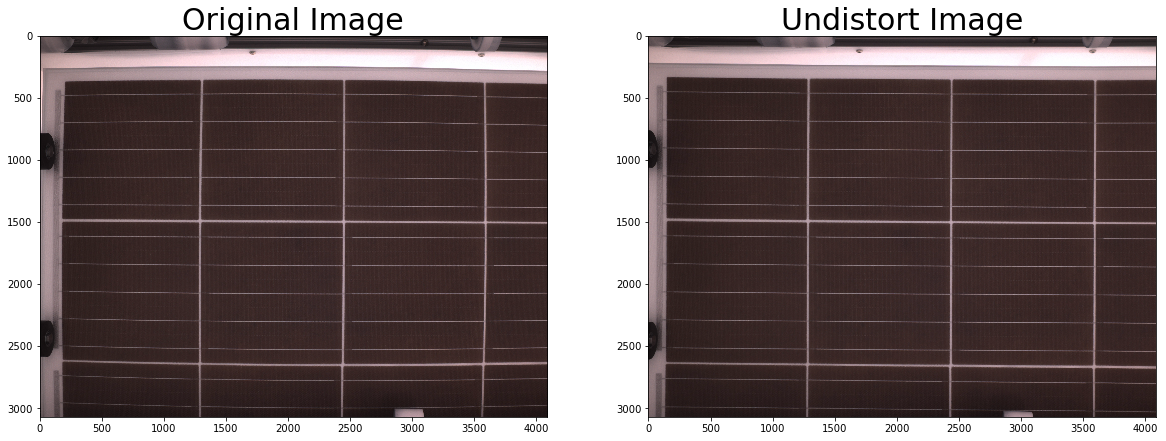

In [9]:
#Test undistortion on an image
img = cv2.imread('./train-cam-xml/cam1/3272009223986_A1.jpg')
dst = undistort(img, './camera_param/cam1.pkl')
#Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistort Image', fontsize=30)
plt.show()

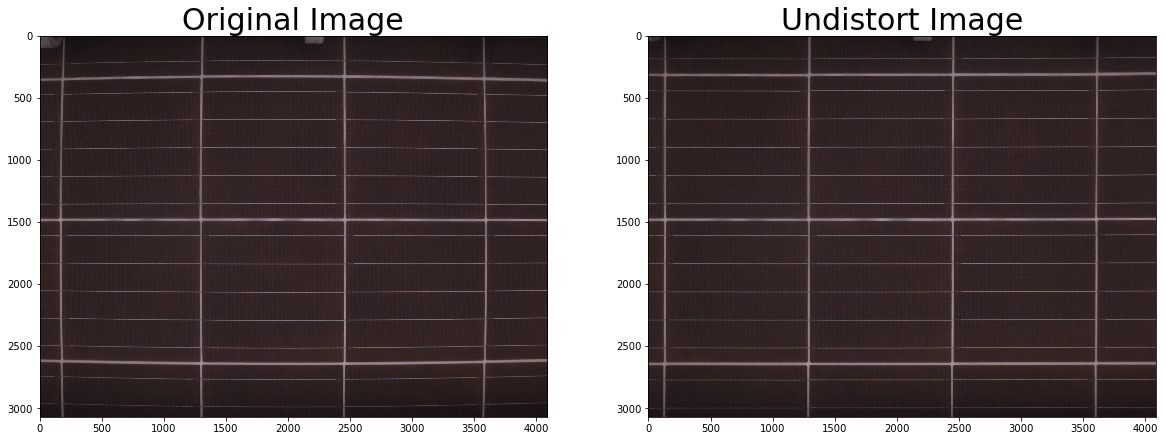

In [10]:
#Test undistortion on an image
img = cv2.imread('./train-cam-xml/cam2/3272009223986_B2.jpg')
dst = undistort(img, './camera_param/cam2.pkl')
#Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistort Image', fontsize=30)
plt.show()

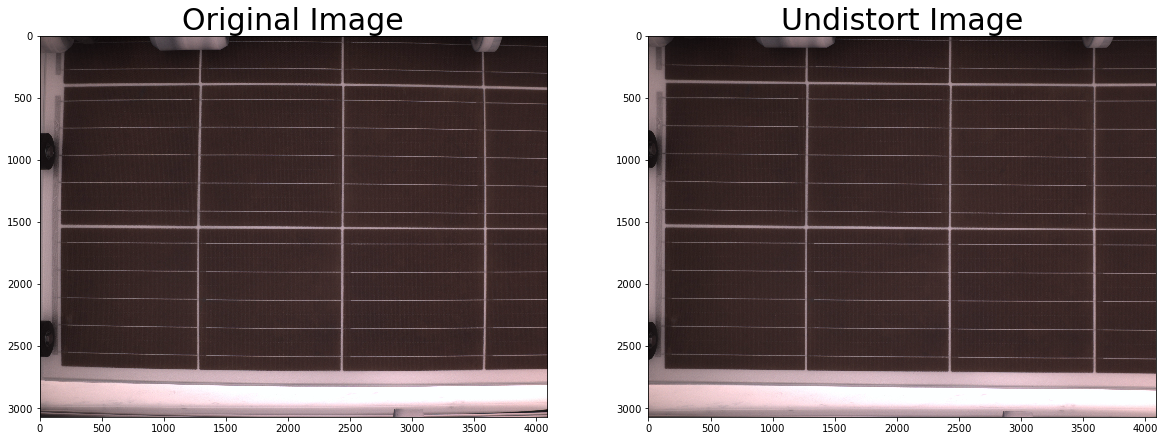

In [12]:
#Test undistortion on an image
img = cv2.imread('../data/20191202/DayFlight/SP/3272009223996_C1.jpg')
dst = undistort(img, './camera_param/cam1.pkl')
#Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistort Image', fontsize=30)
plt.show()